<a href="https://colab.research.google.com/github/Whereamiactually/lyceumcompling10/blob/main/Stylometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Стилометрия

Следующий материал основывается на главе 2 "Установление авторства
с помощью стилометрии" из книги ["Python для хакеров. Нетривиальные задачи и проекты"](https://habr.com/ru/companies/piter/articles/733386/). Вот [тут](https://storage.piter.com/upload/contents/978544612968/978544612968_p.pdf) есть релевантный для нас отрывок.

Мы будем определять, кто является автором произведения "Идиот" - Ф.М. Достоевский и Н.В. Гоголь (представим, что мы этого не знаем). Для этого возьмем по одному произведению каждого автора, про которое точно известно, кто его написал, и сравним каждое из них с "Идиотом".

Тексты я взяла вот [отсюда](https://avidreaders.ru/).

Тексты можно сравнивать по следующим параметрам:

* **Длина слов**. График распределения частотности длин слов в тексте.
* **Длина предложений**. График распределения частотности длин предложений в тексте.
* **Стоп-слова**. График распределения частотности стоп-слов.
* **Части речи**. График распределения частотности слов на основе их синтаксической роли (существительные, местоимения, глаголы, обстоятельства,
определения и пр.).
* **Лексическое разнообразие текста**. Процент уникальных слов от всего текста. То есть нужно посчитать количество уникальных токенов и поделить его на количество всех токенов.
* **Наиболее распространенные слова**. Сравнение наиболее часто встречающихся в тексте слов.
* **Коэффициент Жаккара**. Статистика, используемая для оценки сходства
и разнообразия выборки. Можно почитать вот [тут](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%96%D0%B0%D0%BA%D0%BA%D0%B0%D1%80%D0%B0).

С работой со многими из этих параметров нам поможет библиотека NLTK.

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt') # для word_tokenize
nltk.download('averaged_perceptron_tagger') # для pos_tag

stopwords = nltk.corpus.stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Вначале напишем функцию, которая считывает текстовый файл в строку.

In [2]:
def text_to_string(filename):
    """Считывает текстовый файл в строку."""
    with open(filename) as infile:
        return infile.read() # возвращает строку

In [3]:
strings_by_author = dict()

strings_by_author['gogol'] = text_to_string('mertvye-dushi.txt')
strings_by_author['dostoevsky'] = text_to_string('prestuplenie-i-nakazanie-dr-izd.txt')
strings_by_author['unknown'] = text_to_string('idiot.txt') # пишем uknown, так как автора мы якобы не знаем

In [ ]:
# проверим, все ли нормально считалось
print(strings_by_author['dostoevsky'][:300])

Теперь напишем фукнцию, которая на вход получает словарь, в котором для каждого автора лежит строка с его произведением, и возвращает словарь со списком токенов для каждого из них.

In [5]:
def make_word_dict(strings_by_author):
    """Возвращает словарь со списком токенов для каждого из авторов."""
    words_by_author = dict() # создаем пустой словарь
    for author in strings_by_author: # проходимся по каждому автору
        tokens = nltk.word_tokenize(strings_by_author[author]) # токенизируем произведение
        words_by_author[author] = ([token.lower() for token in tokens # кладем токены в новый словарь
                                    if token.isalpha()]) # избавляемся от знаков препинания
    return words_by_author

In [6]:
tokens_per_author = make_word_dict(strings_by_author)

In [ ]:
tokens_per_author

In [8]:
for author in tokens_per_author: # мы хотим посмотреть на длину каждого произведения в токенах
  print(author, '-', len(tokens_per_author[author]))

gogol - 113158
dostoevsky - 164749
unknown - 202063


Эти тексты далеко не равнозначны по длине.

Но, по-хорошему, тексты должны быть хотя бы примерно одинаковой длины, поэтому нам нужно обрезать более длинные тексты по длине самого короткого (мы предполагаем, что те части текстов, которые в таком случае не войдут в наше исследование, устроены таким же образом, что и те, которые войдут).

In [9]:
import matplotlib.pyplot as plt # для работы с графиками
import collections # для нахождения частотности

In [10]:
LINES = ['-', ':', '--']  # стиль линий для графиков

Построим первый график - посмотрим на частотность слов той или иной длины для каждого автора.

In [21]:
def word_length_test(words_by_author):
    """Рисует график распределения частотности длин слов для каждого автора."""
    plt.figure(1) # присваиваем номер графику
    for i, author in enumerate(words_by_author): # проходимся по каждому автору (enumerate дает каждому автору порядковый номер, начиная с нуля)
        word_lengths = [len(word) for word in words_by_author[author][:len(tokens_per_author['gogol'])]] # проходимся по каждому слову и считаем его длину (количество слов такое же, как в самом коротком тексте)
        dist = dict(collections.Counter(word_lengths)) # считаем частотность слов разной длины и создаем словарь, где ключи - это длины слов
        for num in range(1, 26): # проходимся по каждой возможной длине слова (от 1 до 25)
          if num not in dist.keys(): # если ее не находим, то добавляем ноль в значение ключа
            dist[num] = 0
        sorting = dict(sorted(dist.items())) # сортируем словарь
        #print(sorting)
        plt.plot(sorting.values(), label = author, linestyle = LINES[i]) # рисуем линию для каждого автора
    plt.legend() # рисуем легенду, где указано, какая линия какому автору соответствует
    plt.title('Частотность длин слов для каждого автора')
    plt.xlabel('длина слова')
    plt.ylabel('количество вхождений')
    plt.show() # выводим все вместе

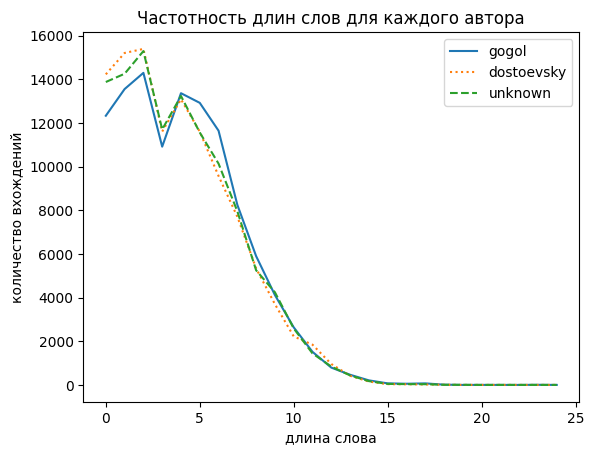

In [22]:
word_length_test(tokens_per_author)

Теперь посмотрим на распределение слов по частям речи для каждого автора!

In [23]:
pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 43.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=85a2125d5e496c04dc440ea8c324c5a0b33e10c26c32e9632e9a02262953032f
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [24]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [25]:
def parts_of_speech_test(words_by_author):
    """Рисует график распределения частотности частей речи для каждого автора."""
    plt.figure(2)
    width = 0.25 # ширина столбцов
    for i, author in enumerate(words_by_author): # проходимся по каждому автору и его токенам
        pos_by_author = [str(morph.parse(word)[0].tag.POS) for word in words_by_author[author][:len(tokens_per_author['gogol'])]] # добавляем часть речь каждого токена в список
        dist = dict(collections.Counter(pos_by_author)) # создаем словарь, где каждой части речи соответствует ее частотность
        dist.pop('None') # некоторые токены почему-то оказываются None, их надо убрать
        sorting = dict(sorted(dist.items(), key = lambda item: item[1], reverse = True)) # сортируем словарь по значениям
        names = list(sorting.keys()) # отдельно сохраняем ключи в список
        values = list(sorting.values()) # отдельно значения
        plt.bar(names, values, width, label = author) # рисуем столбчатую диаграмму

    plt.legend()
    plt.title('Частотность частей речи для каждого автора')
    plt.xlabel('част речи')
    plt.ylabel('количество вхождений')
    plt.xlim([-0.5, 7.5]) # задаем область вывода
    plt.show() # показываем

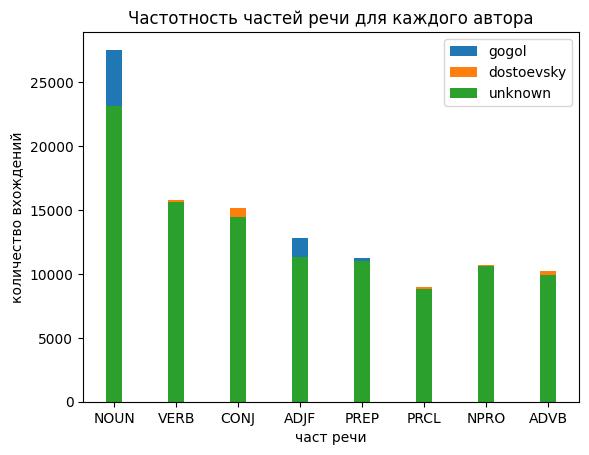

In [26]:
parts_of_speech_test(tokens_per_author) # надо подождать, потому что морфологический разбор производится довольно долго для такого количества токенов

Теперь сравним лексикон авторов с помощью [критерия хи-квадрат](https://blog.skillfactory.ru/glossary/kriteriy-hi-kvadrat/).

Грубо говоря, этот критерий используется для соотнесения ожидаемых результатов с теми, что мы видим на самом деле. В нашем случае последнее - это результаты для текста, автора которого мы знаем, а первое - это результаты для общего текста, сложенного из текстов известного автора и неизвестного (unknown). То есть, например, текст gogol мы сравниваем с текстом gogol+unknown, а текст dostoevsky с текстом dostoevsky+unknown.

Для каждого текста в паре мы хотим найти частотность слов. Давайте в качестве примера посмотрим на пару gogol и gogol+unknown.

Если автором unknown является gogol, то мы ожидаем, что относительная частотность слов в тексте unknown будет примерна равна относительной частотности слов в тексте gogol. Чем больше она отличается, тем, соответственно, вероятнее, что автором unknown является не gogol. И чем больше она отличается, тем выше будет критерий хи-квадрат для каждого слова и для всего текста в целом.

Поэтому мы можем, сравнивания частотность слов в паре gogol и gogol+unknown с помощью критерия хи-квадрат, получить сложением критерий хи-квадрат для всей пары в целом и в итоге сравнить его с парой другого автора, то есть в нашем случае с парой dostoevsky и dostoevsky+unknown.

Наименьший критерий хи-квадрат будет у того автора, текст которого больше похож на текст unknown.

Это все написано очень грубо и приблизительно, в это всё вникать необязательно, просто нужно помнить, что есть какой-то такой статистический тест, с помощью которого можно проверить схожесть лексикона. Тем не менее, нужно примерно понимать, что делает код.

Для начала слова надо лемматизировать, так как мы хотим подсчитать частотность слов и хотим разные формы одного и того же слова считать одним словом.


In [60]:
def lemmatize_list(words_by_author):
    """Возвращает словарь со списками лемматизированных токенов для каждого автора."""
    lemmatized = dict()
    for author in words_by_author:
      lemmas = [morph.parse(word)[0].normal_form for word in words_by_author[author]]
      lemmatized[author] = lemmas
    return lemmatized

In [61]:
lemmatized = lemmatize_list(tokens_per_author)

In [51]:
def vocab_test(words_by_author):
    """Сравнивает словарный запас авторов, используя критерий хи-квадрат."""
    chisquared_by_author = dict()
    for author in words_by_author:
        if author != 'unknown':
            # находит 1000 ниболее частотных слов в списке токенов, получившесмся путем объединения токенов известного и неизвестного автора
            combined_corpus = (words_by_author[author] +
                               words_by_author['unknown']) # объединяем
            author_proportion = (len(words_by_author[author])/
                                 len(combined_corpus)) # вычисляем долю слов известного нам автора
            combined_freq_dist = nltk.FreqDist(combined_corpus) # смотрим частотность слов
            most_common_words = list(combined_freq_dist.most_common(1000)) # список самых частотных слов
            chisquared = 0

            # вычисляет совпадение ожидаемых и получившихся подсчетов
            for word, combined_count in most_common_words:
                observed_count_author = words_by_author[author].count(word) # смотрим частотность слова только в тексте известного нам автора (то есть это то, что мы действительно наблюдаем)
                expected_count_author = combined_count * author_proportion # умножаем частотность слова в комбинированном списке токенов на долю токенов автора (то есть это то, что мы ожидаем)
                # таким образом у нас получается две частотности для одного слова
                chisquared += ((observed_count_author -
                                expected_count_author)**2 /
                               expected_count_author) # это формула, по которой мы вычисляем критерий хи-квадрат
                # каждый раз мы увиличиваем сумму на хи-квадрат для отдельного слова
            chisquared_by_author[author] = chisquared # кладем общую сумму для всех слов в словарь под именем автора
            print('Хи-квадрат для {} = {:.1f}'.format(author.capitalize(), chisquared))

    most_likely_author = min(chisquared_by_author, key = chisquared_by_author.get)
    print('Судя по распределению частотностей слов, наиболее вероятно, что автором является {}\n'.format(most_likely_author.capitalize()))

In [62]:
vocab_test(lemmatized)

Хи-квадрат для Gogol = 15361.8
Хи-квадрат для Dostoevsky = 9916.9
Наиболее вероятно, что автором является Dostoevsky



Есть еще так называемый коэффициент Жаккара. С помощью него можно вычислить схожесть набора используемых слов (в предыдущем пункте мы смотрела на их частотность), то есть пропорцию общих слов ко всем необщим словам.

In [64]:
def jaccard_test(words_by_author):
    """Вычисляет коэффициент Жаккарта для каждого текста в сравнении с текстом unknown."""
    jaccard_by_author = dict()
    unique_words_unknown = set(words_by_author['unknown']
                               [:len(tokens_per_author['gogol'])]) # функция set() удаляет повторы из списка, то есть получается список уникальных слов
    authors = (author for author in words_by_author if author != 'unknown') # собираем имена авторов (двух), но не unknown, так как с ним будем сравнивать
    for author in authors: # проходимся по каждому автору
        unique_words_author = set(words_by_author[author][:len(tokens_per_author['gogol'])]) # собираем список уникальных слов для автора
        shared_words = unique_words_author.intersection(unique_words_unknown) # находим пересечение списков слов (то есть общие слова)
        jaccard_sim = (float(len(shared_words))/ (len(unique_words_author) +
                                                  len(unique_words_unknown) -
                                                  len(shared_words))) # так вычисляет коэффициент Жаккара
        jaccard_by_author[author] = jaccard_sim # кладем результат в словарь под именем автора
        print('Коэффициент Жаккарта для {} = {}'.format(author.capitalize(), jaccard_sim))

    most_likely_author = max(jaccard_by_author, key = jaccard_by_author.get) # чем больше пропорция общих слов, тем, соответственно, вероятнее, что автором является именно этот писатель
    print('Судя по схожести лексики, наиболее вероятно, что автором является {}'.format(most_likely_author.capitalize()))

In [65]:
jaccard_test(lemmatized)

Коэффициент Жаккарта для Gogol = 0.3197589723215468
Коэффициент Жаккарта для Dostoevsky = 0.4047163798597833
Судя по схожести лексики, наиболее вероятно, что автором является Dostoevsky


Все критерии указывают в пользу того, что Ф.М. Достоевский является автором "Идиота", что, безусловно, верно!

# Ваш проект

Вам нужно выбрать три прозаических текста из примерно одного времени (длина особо не играет роли, но важно, чтобы текст был больше 50000 слов). Автором двух из них должен являться один и тот же писатель (как было у нас). Из этих двух вам нужно выбрать один, автороство которого вы хотите проверить (мы тогда выбрали "Идиот").

Вам нужно проверить эти три текста по:
* критерию **лексического разнообразия текста** (см. в самое начало тетрадки),
* любым **двум** критериям из тех, что мы проходили на паре (по сути это просто скормить ваш словарь "автор:токены" в уже готовые функции),
* и **одному** критерию из тех, что мы не проходили (**график распределения частотности стоп-слов** (аналогично графику распределения частотности частей речи) или **график распределения частотности длин предложений** (аналогично графику распределения частотности длин слов)). То есть вам нужно взять готовую функцию из этой тетрадки и модифицировать её под тот критерий, который вы выбрали.

Также для любого из текстов вам нужно создать либо облако слов, либо график встречаемости имен тех или иных персонажей в тексте. Во время презентации нужно будет это вкратце прокомментировать.

Во время презентации вам надо прокомментировать совсем вкратце код, который вы написали (для функций, которые вы сами придумали), а не вкратце - результаты, которые вы получили. Правильный ли результат вы получили? Показалось ли вам что-то необычным? И другое в таком духе.

### Подсказки

1. Подсказки для критерия **лексического разнообразия текста** можно найти [тут](https://habr.com/ru/articles/536858/).
2. Для **вычисления длин предложений** вам надо вначале сделать список списков слов по предложениям (вот в [этой тетрадке](https://colab.research.google.com/drive/10Hrqg1kvoKPr294-rFF3xibY_oBSnrMu?usp=sharing) перед старым домашним заданием есть код, который поможет вам с этим). Затем, проходясь по каждому списку слов предложений, вам нужно считать его длину и складывать длину в новый список со всеми длинами предложений.
3. Для **вычисления частотности стоп-слов** вам нужно создать список слов, в который добавляются только те слова, которые содержатся в списке стоп-слов NLTK (можно использовать и другую проверку на стоп-словность).
4. Для того, чтобы построить **облако слов** или **график встречаемости имен**, вам нужно скормить тому коду, что в [этой тетрадке](https://colab.research.google.com/drive/1bq-VOPmyQUo0SN02jeWzP9uEI0zF0Esh?usp=sharing), список лемматизированных слов (в этой тетрадке есть функция, которая лемматизирует).